# **Прогнозирование размеров сварного шва при электронно-лучевой сваркетонкостенных конструкций аэрокосмического назначения**

В качестве исходных данных были взяты результаты экспериментальных
исследований, проводимых в целях улучшения технологического процесса
электронно-лучевой сварки изделия, сборка которого состоит из элементов,
состоящих из разнородного материала.
Установка электронно-лучевой сварки, на которой проводились
исследования, предназначена для сварки электронным лучом в глубоком вакууме
деталей сборочных единиц из нержавеющих сталей, титановых, алюминиевых
и специальных сплавов.
Существующая установка электронно-лучевой сварки обеспечивает
повторяемость режимов в рамках возможностей реализованной системы
управления. Работы по сварке выполнялись на образцах-имитаторах,
соответствующих технологическому изделию.
Для уменьшения вложения энергии при сварке:
1. Снижалась величина сварочного тока (IW);
2. Увеличивался ток фокусировки электронного пучка (IF);
3. Увеличивалась скорость сварки (VW);
4. Менялось расстояние от поверхности образцов до электронно-оптической
системы (FP).
По совокупности параметров технологических режимов обеспечивались
минимально возможные размеры сварных швов: глубина шва (Depth) и ширина
шва (Width).
В процессе выполнения работ была произведена электронно-лучевая сварка
18-ти единиц образцов. Результаты металлографического контроля
по размерам сварного шва для каждого образца проводились в 4-х поперечных
сечениях сварного шва. Ускоряющее напряжение было постоянным в диапазоне
19,8 – 20 кВ. Набор полученных данных собраны в составе режимов сварки,
размеров сварочных швов в поперечных сечениях всех образцов. Статистические
показатели набора обучающих данных указаны в табл. 1.

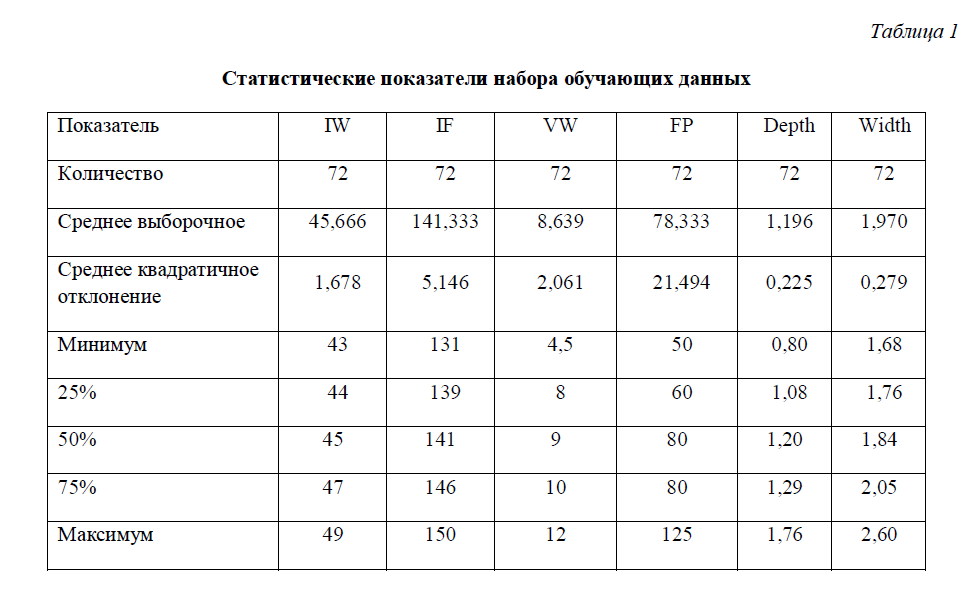

**Задание:** Решить задачу регрессии (одним или несколькими методами)
для предсказания глубины и ширины сварного соединения, выполнив
необходимые этапы (разведочный анализ, предобработка)

## Загрузка библиотек

In [ ]:
# устноавка нестандартных библиотек

! pip install catboost --quiet

In [ ]:
# загрузим все нужные библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

pd.options.display.max_colwidth = 130

# для отладки закомментить
import warnings
warnings.simplefilter('ignore')

## Функции

In [ ]:
# функция для описательной статистики, вывода дубликатов и типов данных

def describe_df(data, datetime_as_num=True):

    '''
    Функция получает на ввод dataframe (data) и условие как выводить данные (dt_is_numeric) для datetime:
    - True - для подсчетов статистики как int
    - False - для подсчетов статистики как object
    После поочередно выводит описательную статистику для каждого типа объекта
    Дальше функция выводит количество и виды типов данных, количество явных дубликатов
    '''

    for t in data.dtypes.unique():
        print('{:=^50}'.format(f' dtype = {t}'))
        print(data.describe(include=t, datetime_is_numeric=datetime_as_num))
        print('='*50, end='\n\n')
    print(data.info())
    print('='*50, end='\n\n')
    print(f'Количество дубликатов {data.duplicated().sum()}')

In [ ]:
def tables_plot (data, type_plot, table_name):

    '''
    Функция строит графики по всем колонкам датасета
    в зависимости от типа графика - type_plot
    Так же опредляется название графика - table_name
    '''

    # Определим количество столбцов в каждой строке системы графиков
    columns_per_row = 3

    # Определим количество строк
    num_rows = len(data.columns) // columns_per_row + 1

    # Создадим системы координат для графиков
    fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 10))

    # Перебор всех столбцов и построение гистограмм
    for i, column in enumerate(df.columns):
        ax = axes[i // columns_per_row, i % columns_per_row]
        if type_plot == 'hist':
          ax.hist(data[column], bins = 20, edgecolor='k')
          ax.set_ylabel('Количество')
        else:
          ax.boxplot(df[column])
          ax.set_ylabel('Значения')
        ax.set_title(f'{table_name} {column}')

    # Удалим пустые подграфики, если количество столбцов не делится равномерно на тройки
    for i in range(len(data.columns), num_rows * columns_per_row):
        fig.delaxes(axes[i // columns_per_row, i % columns_per_row])

    # Подгоним расположение графиков
    plt.tight_layout()
    plt.show()

## Выгрузка датасета

https://drive.google.com/file/d/1hBFGNoVIbnORcyorTamlkVolfiAhcLTo/view?usp=sharing

In [ ]:
! gdown --id 1hBFGNoVIbnORcyorTamlkVolfiAhcLTo

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hBFGNoVIbnORcyorTamlkVolfiAhcLTo
To: /content/Датасет_к_Практическому_заданию.zip
100% 11.3k/11.3k [00:00<00:00, 30.1MB/s]


In [ ]:
! unzip /content/Датасет_к_Практическому_заданию.zip

Archive:  /content/Датасет_к_Практическому_заданию.zip
  inflating: ebw_data.txt            
  inflating: ebw_data.xlsx           
  inflating: ebw_data.csv            


## Описание данных

In [ ]:
#  создаем датасет
df = pd.read_csv('/content/ebw_data.csv')

### Таблица `df`

Датасет содержит колонки:
- `IW` — величина сварочного тока
- `IF` — ток фокусировки электронного пучка
- `VW` — скорость сварки
- `FP` — расстояние от поверхности образцов до электронно-оптической
системы
- `Depth` — глубина шва
- `Width` — ширина шва


In [ ]:
# посмотрим на первые 10 строк
df.head(10)

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48
5,45,140,4.5,80,1.72,2.48
6,45,140,4.5,80,1.64,2.52
7,45,140,4.5,80,1.64,2.56
8,45,140,8.0,80,1.20,2.00
9,45,140,8.0,80,1.20,1.96


In [ ]:
#  описательная статистика
describe_df(df, True)

================== dtype = int64==================
              IW          IF          FP
count  72.000000   72.000000   72.000000
mean   45.666667  141.333333   78.333333
std     1.678363    5.145763   21.493530
min    43.000000  131.000000   50.000000
25%    44.000000  139.000000   60.000000
50%    45.500000  141.000000   80.000000
75%    47.000000  146.000000   80.000000
max    49.000000  150.000000  125.000000

================= dtype = float64=================
              VW      Depth      Width
count  72.000000  72.000000  72.000000
mean    8.638889   1.195556   1.970417
std     2.061078   0.225081   0.279040
min     4.500000   0.800000   1.680000
25%     8.000000   1.080000   1.760000
50%     9.000000   1.200000   1.840000
75%    10.000000   1.290000   2.050000
max    12.000000   1.760000   2.600000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  


In [ ]:
# процент дубликатов в датасете
df.duplicated().sum() / df.shape[0] * 100

9.722222222222223

<font color='orange'><b>*Наблюдение_*</b></font>
- датасет состоит из 72 строк
- в датасете нет пустых значений
- есть 7 дубликотов (10%), но по характеру данных я бы не стала удалять эти дубли, так как в эксперименте вполне могут попасться одинаковые значения. Можно обучить данные с этими дублями и без них и посмортеть на результат
По параметрам:
- `IW`, `IF`, `VW` — медианное значение совсем немного отличается от среднего, что говорит о том, что выбросов мало. стандартное отклонение для таких значений небольшое, что говорит о том, что значения находятся рядом
- `FP` — тут по стандартному отклонению можем сказать, что есть относительно небольшая вариабильность значений
- `Depth`, `Width` — с маленьким std и почти одинаковыми средними и медианнами

## Исследовательский анализ данных (EDA)

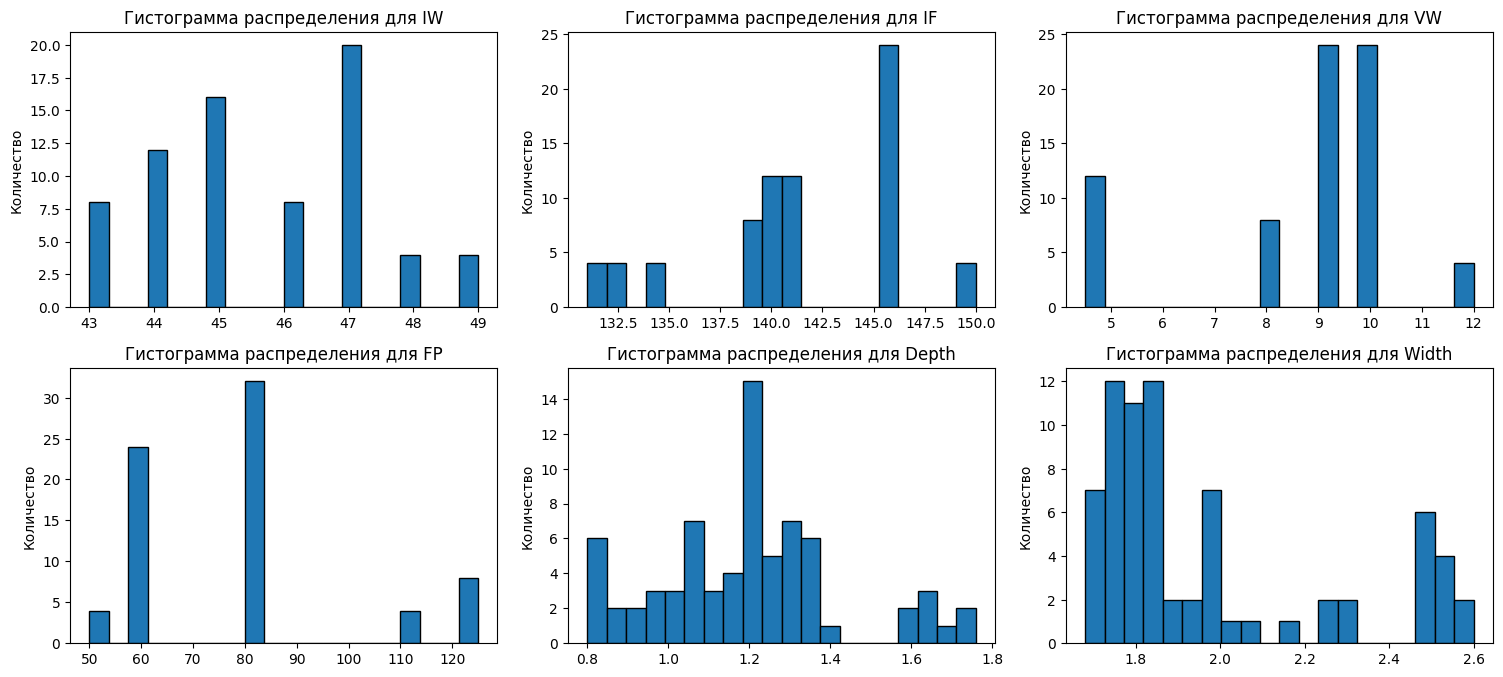

In [ ]:
tables_plot (df, 'hist', 'Гистограмма распределения для')

<font color='orange'><b>*Наблюдение_*</b></font>
- `IW` — чаще всего величина сварочного тока была 47 в экспериментах
- `IF` — чаще всего ток фокусировки электронного пучка был 145.5
- `VW` — скорость сварки чаще всего была 9 и 10
- `FP` — расстояние от поверхности образцов до электронно-оптической
системы
- `Depth` — чаще всего глубина шва равна 1.2. распределение отдалено похоже на нормальное, но с изолированным пиком. Причиной может быть включение данных из другого распределения или появление ошибки измерения. Стоит перепроверить измерения и вычисления, может возможно выделить условия (оборудование, время), которые могут служить причиной образования изолированного пика.
- `Width` — чаще всего ширина шва равна 1.2. распределение отдалено похоже на нормальное, но скошенное влево. Подобное распределение возможно, когда невозможно получение значений больше или меньше определённой величины, либо при наличии одностороннего поля допуска, также это может быть влияние точности заготовок при их механической обработке

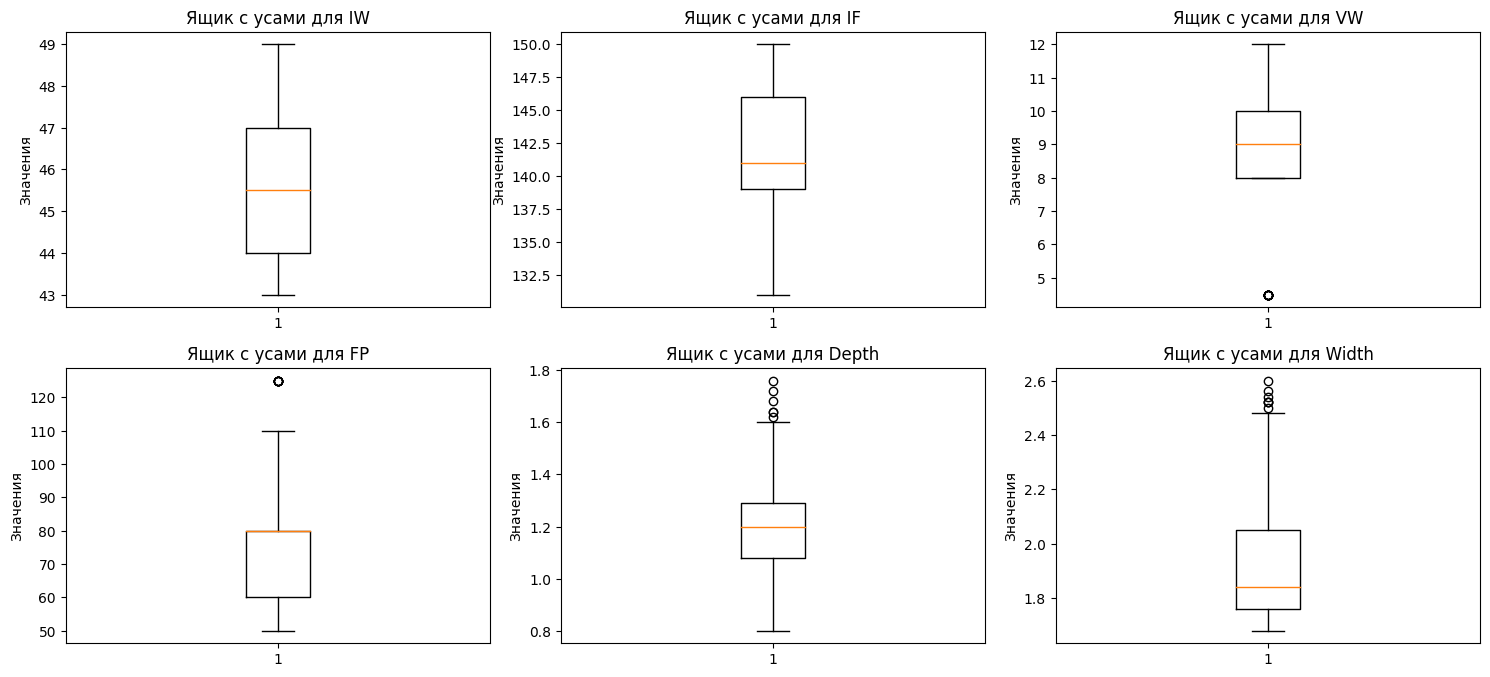

In [ ]:
tables_plot (df, 'boxplot', 'Ящик с усами для')

<font color='orange'><b>*Наблюдение_*</b></font>
- `IW` — у величины сварочного тока нет выбросов. Степень разброса больше после 75%
- `IF` — У тока фокусировки электронного пучка больше разброс в нижней части графика. Степень разброса больше до 25%
- `VW` — у скорость сварки есть один выброс и совсем нет разброса до нижнего квартиля
- `FP` — для расстояние от поверхности образцов до электронно-оптической
системы так же видим единичный выброс и медианна равна верхнему квартилю
- `Depth` — для глубины шва есть много выбросов после верхнего уса
- `Width` — у ширина шва есть много выбросов после верхнего уса

У глубины и ширины шва много точек выше верхней границы нормального распределения данных.

Выбросы могут говорить о различных аспектах данных:

- Аномалии: Выбросы могут представлять собой аномалии или необычные события, которые отличаются от обычных наблюдений. Например, в финансовых данных выбросы могут свидетельствовать о крупных финансовых кризисах или аномальных сделках.

- Ошибка в данных: Выбросы могут быть результатом ошибок в данных, таких как опечатки или некорректные измерения.

- Естественная вариабельность: В редких случаях выбросы могут отражать естественную вариабельность данных, и они могут быть важными для понимания экстремальных ситуаций.

- Необычные события: Выбросы могут также указывать на необычные события, которые могут иметь важное значение в контексте анализа данных.

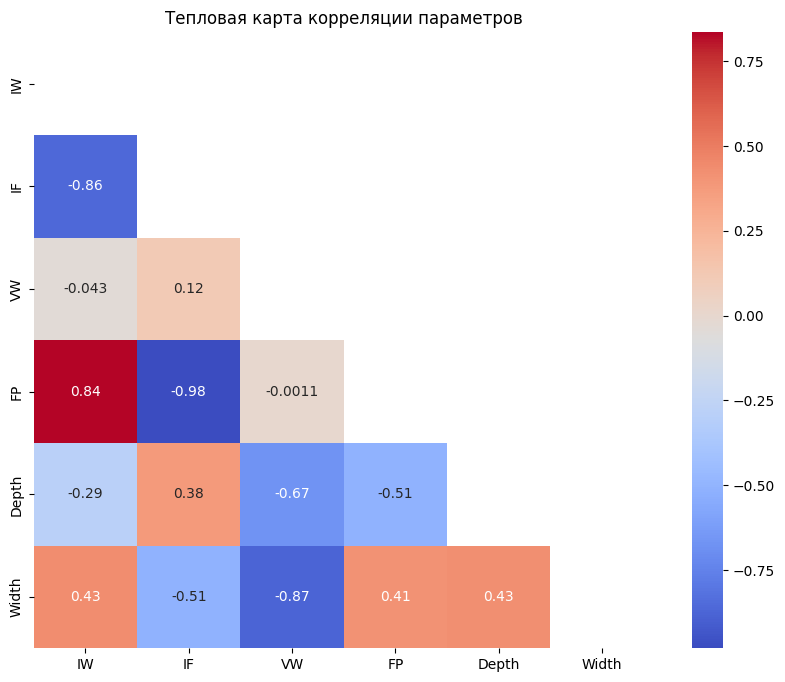

In [ ]:
# Создаем матрицу корреляции
corr_matrix = df.corr()

# Создаем тепловую карту
plt.figure(figsize=(10, 8))  # Размер графика
sns.heatmap(corr_matrix , annot=True, mask=np.triu(df.corr()), cmap= 'coolwarm')
plt.title('Тепловая карта корреляции параметров')
plt.show()

<font color='orange'><b>*Наблюдение_*</b></font>
- Наисильнейшая положительная связь у "расстояния от поверхности образцов до электронно-оптической системы" и "величины сварочного тока", что значит чем больше расстояние, тем больше сварочный ток
- Наисильнейшая отрицательная связь у "расстояния от поверхности образцов до электронно-оптической системы" и "тока фокусировки электронного пучка", что значит чем больше расстояние, тем меньше ток луча и наоборот
- на целевые показатели больше всего влияют:
* на Depth: Width (+) и VW (-)
* на Width: IW (+) и VW (-)

Так как есть сильно коррелирующие признаки, то возможна мультиколлинеарность и надо будет с ней бороться.


<font color='green'><b>*Итог по предобработке и EDA*</b></font>
- в данном датасете я не вижу, что можно было исправить: пропусков нет; дубликаты есть, но так как это эксперимент, такие значения могут быть; есть выбросы, но это тоже нормально для исследования
- провели анализ данных, увидели закономерности и изучили их

Теперь мы готовы к подбору модели для предсказания.

## Обучение моделей регрессии на тренировочных данных и выбор модели

Проверим след. модели:
- Линейную регрессию
- Ridge регрессию
- CatBoost регрессию

Первая не оптимизирует мультиколлинеарность, вторая должна справится лучше, а третья, по идее, сама все оптимизирует.

Будем оценивать качество модели по:
- время работы модели
- MSE
- R2

Оценивать модели будем с помощью кросс-валидации - cross_val_score (https://academy.yandex.ru/handbook/ml/article/kross-validaciya)


In [ ]:
# сначала разделим датасет на обучающие и тестовые выборки
# создаем массив признаков
X = df.drop(columns=['Depth', 'Width']).to_numpy()

# создаем массив целевых значений
y = df[['Depth', 'Width']].to_numpy()

# делим данные на тестовые и тренировочные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Масштабирование признаков обучающей выборки

Так как мы не знаем размерность данных и наверняка данные разного масштаба, для корректного обучения некоторых моделей будет полезно привести признаки к одному масштабу. Для этого будем использовать функцию StandardScaler.

In [ ]:
# обучаем StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

# Создаем копии train и test, чтобы иметь возможность обучаться как на изначальных, так и на масштабированных признаках
X_train_scale = X_train.copy()
X_test_scale = X_test.copy()

# Масштабируем признаки
X_train_scale = scaler.transform(X_train_scale)
X_test_scale  = scaler.transform(X_test_scale)

### Линейная регрессия

In [ ]:
%%time
# инициализируем модель
linereg = LinearRegression()

# Определяем фолды для CV
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# вычисляем средние показатели на кросс-валидации
score_linereg_M = cross_val_score(linereg, X_train, y_train, scoring= 'neg_mean_squared_error', cv=folds).mean()
score_linereg_R = cross_val_score(linereg, X_train, y_train, scoring= 'r2', cv=folds).mean()

# Выводим информацию
print('-'*50)
print('Итоговое значение MSE ==', score_linereg_M)
print('Итоговое значение R2 ==', score_linereg_R)
print('-'*50)

--------------------------------------------------
Итоговое значение MSE == -0.007295596044197548
Итоговое значение R2 == 0.8261222867027775
--------------------------------------------------
CPU times: user 31 ms, sys: 151 µs, total: 31.2 ms
Wall time: 31.2 ms


<font color='orange'><b>*Наблюдение_*</b></font>

MSE и коэф. детереминации достаточно хорошо выглядт (маленькая MSE и R2 больше 80%).

#### Проверим результат на масштабированных параметрах:

In [ ]:
# инициализируем модель
linereg = LinearRegression()

# Определяем фолды для CV
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# вычисляем средние показатели на кросс-валидации
score_linereg_M = cross_val_score(linereg, X_train_scale, y_train, scoring= 'neg_mean_squared_error', cv=folds).mean()
score_linereg_R = cross_val_score(linereg, X_train_scale, y_train, scoring= 'r2', cv=folds).mean()

# Выводим информацию
print('-'*50)
print('Итоговое значение MSE ==', score_linereg_M)
print('Итоговое значение R2 ==', score_linereg_R)
print('-'*50)

--------------------------------------------------
Итоговое значение MSE == -0.007295596044197583
Итоговое значение R2 == 0.8261222867027767
--------------------------------------------------


<font color='orange'><b>*Наблюдение_*</b></font>

Масштабирование почти не изменило результат.

### Проверим модель на датасете без дублей

In [ ]:
df_c = df.drop_duplicates ()

In [ ]:
# создаем массив признаков
X = df_c.drop(columns=['Depth', 'Width']).to_numpy()

# создаем массив целевых значений
y = df_c[['Depth', 'Width']].to_numpy()

# делим данные на тестовые и тренировочные
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
%%time
# инициализируем модель
linereg = LinearRegression()

# Определяем фолды для CV
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# вычисляем средние показатели на кросс-валидации
score_linereg_M = cross_val_score(linereg, X_train_c, y_train_c, scoring= 'neg_mean_squared_error', cv=folds).mean()
score_linereg_R = cross_val_score(linereg, X_train_c, y_train_c, scoring= 'r2', cv=folds).mean()

# Выводим информацию
print('-'*50)
print('Итоговое значение MSE ==', score_linereg_M)
print('Итоговое значение R2 ==', score_linereg_R)
print('-'*50)

--------------------------------------------------
Итоговое значение MSE == -0.007623867668634735
Итоговое значение R2 == 0.8598938277608005
--------------------------------------------------
CPU times: user 28.2 ms, sys: 0 ns, total: 28.2 ms
Wall time: 32 ms


<font color='orange'><b>*Наблюдение_*</b></font>

На очищенных данных R2 чуть лучше, ошибка такая же. Сильного отличия не увидела.



### Ridge регрессия

In [ ]:
%%time
# Определяем фолды для CV
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# инициализируем модель
ridge_M = RidgeCV(scoring='neg_mean_squared_error', cv=folds)
ridge_R = RidgeCV(scoring='r2', cv=folds)

# вычисляем средние показатели на кросс-валидации
score_ridge_M = cross_val_score(ridge_M, X_train, y_train, scoring='neg_mean_squared_error', cv=folds).mean()
score_ridge_R = cross_val_score(ridge_R, X_train, y_train, scoring='r2', cv=folds).mean()

# Выводим информацию
print('-'*50)
print('Итоговое значение MSE ==', score_ridge_M)
print('Итоговое значение R2 ==', score_ridge_R)
print('-'*50)

--------------------------------------------------
Итоговое значение MSE == -0.007292857918359441
Итоговое значение R2 == 0.8211959892951357
--------------------------------------------------
CPU times: user 276 ms, sys: 10.8 ms, total: 286 ms
Wall time: 281 ms


#### Проверим результат на масштабированных параметрах:

In [ ]:
# Определяем фолды для CV
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# инициализируем модель
ridge_M = RidgeCV(scoring='neg_mean_squared_error', cv=folds)
ridge_R = RidgeCV(scoring='r2', cv=folds)

# вычисляем средние показатели на кросс-валидации
score_ridge_M = cross_val_score(ridge_M, X_train_scale, y_train, scoring='neg_mean_squared_error', cv=folds).mean()
score_ridge_R = cross_val_score(ridge_R, X_train_scale, y_train, scoring='r2', cv=folds).mean()

# Выводим информацию
print('-'*50)
print('Итоговое значение MSE ==', score_ridge_M)
print('Итоговое значение R2 ==', score_ridge_R)
print('-'*50)

--------------------------------------------------
Итоговое значение MSE == -0.007340106260525272
Итоговое значение R2 == 0.8243753752740325
--------------------------------------------------


<font color='orange'><b>*Наблюдение_*</b></font>

Эта модель на масштабируемых данных и на изначальных показала почти одинаковый результат. Работает модель медленнее, чем линейная и показатели особо не отличаются от нее.

### CatBoost

In [ ]:
%%time
# задаем в словаре параметры CatBoostRegressor
params = {
    'random_state': 42,
    'max_depth': 10,
    'leaf_estimation_method': 'Gradient',
    'bootstrap_type': 'Bernoulli',
    'loss_function': 'MultiRMSE',
    'eval_metric': 'MultiRMSE',
    'verbose': 1000
    }

# инициализируем модель CatBoostRegressor
catb = CatBoostRegressor(**params)

# обучаем модель
catb.fit(X_train, y_train)

# Определяем фолды для CV
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# вычисляем средние показатели на кросс-валидации
score_catb_M = cross_val_score(catb, X_train, y_train, scoring= 'neg_mean_squared_error', cv=folds).mean()
score_catb_R = cross_val_score(catb, X_train, y_train, scoring= 'r2', cv=folds).mean()

# Выводим информацию
print('-'*50)
print('Итоговое значение MSE ==', score_catb_M)
print('Итоговое значение R2 ==', score_catb_R)
print('-'*50)

0:	learn: 0.3296876	total: 46.5ms	remaining: 46.5s
999:	learn: 0.0695901	total: 2.89s	remaining: 0us
0:	learn: 0.3227926	total: 2.26ms	remaining: 2.25s
999:	learn: 0.0595083	total: 1.75s	remaining: 0us
0:	learn: 0.3395723	total: 3.91ms	remaining: 3.91s
999:	learn: 0.0698729	total: 1.45s	remaining: 0us
0:	learn: 0.3470429	total: 311us	remaining: 311ms
999:	learn: 0.0748642	total: 2.11s	remaining: 0us
0:	learn: 0.3439760	total: 335us	remaining: 335ms
999:	learn: 0.0642811	total: 1.44s	remaining: 0us
0:	learn: 0.2875932	total: 279us	remaining: 280ms
999:	learn: 0.0608102	total: 1.77s	remaining: 0us
0:	learn: 0.3227926	total: 292us	remaining: 293ms
999:	learn: 0.0595083	total: 2.46s	remaining: 0us
0:	learn: 0.3395723	total: 278us	remaining: 278ms
999:	learn: 0.0698729	total: 1.51s	remaining: 0us
0:	learn: 0.3470429	total: 261us	remaining: 262ms
999:	learn: 0.0748642	total: 1.51s	remaining: 0us
0:	learn: 0.3439760	total: 955us	remaining: 955ms
999:	learn: 0.0642811	total: 2.02s	remaining: 0

<font color='orange'><b>*Наблюдение_*</b></font>



По всем показателям эта модель лучше. Выберем ее для проверки на тестовых данных.

На масштабированных фичах пробовать не будем, т.к. CatBoost сам умеет с этим работать, результат вряд ли будет значительным.

## Проверка качества модели на тестовых данных

In [ ]:
# получаем предсказания модели на тестовой выборке
predicted_catb = catb.predict(X_test)

# вычисляем MSE и R2
mse = mean_squared_error(y_test, predicted_catb)
r2 = r2_score(y_test, predicted_catb)

# Выводим информацию
print('-'*50)
print(f"Среднеквадратическая ошибка: {mse}")
print(f"Коэффициент детерминации: {r2}")
print('-'*50)

--------------------------------------------------
Среднеквадратическая ошибка: 0.004322305920971764
Коэффициент детерминации: 0.9320004302585294
--------------------------------------------------


<font color='orange'><b>*Наблюдение_*</b></font>

На тестовых данных модель по моему мнению показвает очень неплохие результаты.

### Сравнение качества с dummy

Для проверки предсказательной силы полученной модели сравним ее результат с самой простой моделью dummy, которая просто предсказывает всегда среднее значение.

In [ ]:
# инициализируем модель
dummy = DummyRegressor(strategy="mean")

# обучаемся на тесте
dummy.fit(X_train, y_train)

# получаем предсказания модели на тестовой выборке
predicted_dummy = dummy.predict(X_test)

# вычисляем MSE и R2
mse = mean_squared_error(y_test, predicted_dummy)
r2 = r2_score(y_test, predicted_dummy)

# Выводим информацию
print('-'*50)
print(f"Среднеквадратическая ошибка: {mse}")
print(f"Коэффициент детерминации: {r2}")
print('-'*50)

--------------------------------------------------
Среднеквадратическая ошибка: 0.09335885811018771
Коэффициент детерминации: -0.1925153877778727
--------------------------------------------------


<font color='orange'><b>*Наблюдение_*</b></font>

Как мы видим, полученный результат намного хуже того, что мы смогли добиться с помощью модели CatBoost.

До начала обучения мы строили мрицату корреляции, чтобы увидеть возможные взаимосвязи между целевыми признаками и фичами. Теперь у нас есть модель с достаточно высокой предсказательной силой.
Попробуем посмотреть, какие взаимосвязи смогла установить наша модель.

In [ ]:
# Смотрим важность фичей
# используем встроенный метод выбранно модели
table = catb.get_feature_importance(prettified=True)

In [ ]:
# так как мы анализировали массивы, а не столбцы датасета, то мы потеряли названия параметров (фичей)
# восстановим эти данные

data = {'Feature Id': ['0', '1', '2', '3'],
        'Параметры': ["IW", "IF", "VW", "FP"]}
names = pd.DataFrame(data)

table = table.merge(names, on='Feature Id', how='left').drop(columns = 'Feature Id')

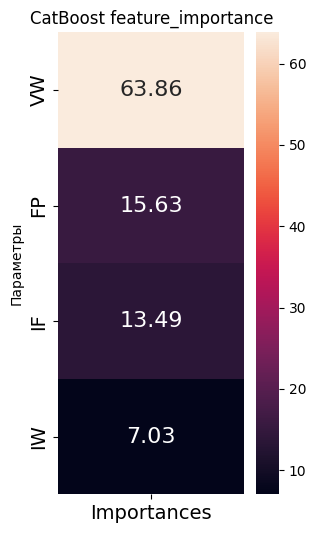

In [ ]:
# Визуализируем взаимосвязи
plt.figure(figsize=(3,6))
sns.heatmap((table.set_index('Параметры')),
            annot=True,
            fmt=".2f",
            annot_kws={'fontsize': 16}
           )
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('CatBoost feature_importance')
plt.show()

In [ ]:
# сравним какая корреляция была по отдельным целевым показателям

print(f"Depth \n{df.corrwith(df['Depth']).sort_values()}")
print('*'*20)
print(f"Width \n{df.corrwith(df['Width']).sort_values()}")

Depth 
VW      -0.671437
FP      -0.510748
IW      -0.289568
IF       0.376084
Width    0.425391
Depth    1.000000
dtype: float64
********************
Width 
VW      -0.874257
IF      -0.510167
FP       0.412962
Depth    0.425391
IW       0.434869
Width    1.000000
dtype: float64


<font color='orange'><b>*Наблюдение_*</b></font>

Мы получли похожую картину.

Таким образом модель CatBoost смогла выявить важность зависимостей между переменными и целевыми параметрами. Это очень ценная информация, т.к. используя ее можно проводить виртуальные эксперименты без траты времени и ресурсов.

<font color='green'><b>*Итог по работе с моделями*</b></font>

- Мы оценили работу трех моделей и выбрали CatBoost по наилучшим показателям.

<font color='blue'><b>*ВЫВОД*</b></font>

- Были загружены и проанализированы данные экспериментов
- Была подобрана модель для предсказаний размеров сварного шва (глубина и ширина) с высокой коэффициентом детерминации и низким MSE.



<font color='red'><b>*Комментарий*</b></font>

Было бы здорово знать единицы измерения для всех параметров.. а то сложно оценивать адекватность, не понимая в какой шкале ты находишься.


